# 한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

# Evn

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip', 'kowiki']

# Word2Vec

## Tutorial

In [ ]:
# 입력 문장
sentences = [
    "나는 학생 입니다",
    "당신은 수학 선생님 입니다",
    "나는 선생님 입니다",
    "당신은 수학 학생 입니다"
]

In [ ]:
words = []
for line in sentences:
    for w in line.split():
        words.append(w)

words = list(dict.fromkeys(words))
words

['나는', '학생', '입니다', '당신은', '수학', '선생님']

In [ ]:
word_to_id = {}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

{'나는': 0, '당신은': 3, '선생님': 5, '수학': 4, '입니다': 2, '학생': 1}

In [ ]:
inputs = np.array([word_to_id["수학"]])
labels = np.array([word_to_id["선생님"]])
inputs, labels

(array([4]), array([5]))

In [ ]:
n_vocab = len(word_to_id)

In [ ]:
V = tf.keras.layers.Embedding(n_vocab, 4)
v_c = V(inputs)
v_c

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.04810704, -0.03535189,  0.04945729,  0.02813626]],
      dtype=float32)>

In [ ]:
V.get_weights()[0].shape

(6, 4)

In [ ]:
U = tf.keras.layers.Dense(n_vocab, use_bias=False)
vU = U(v_c)
vU

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[-0.03733963, -0.0234975 ,  0.04844721,  0.01608931,  0.00769082,
         0.01284879]], dtype=float32)>

In [ ]:
U.get_weights()[0].shape

(4, 6)

In [ ]:
vU_exp = tf.exp(vU)
vU_exp

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.9633489, 0.9767764, 1.0496399, 1.0162195, 1.0077205, 1.0129317]],
      dtype=float32)>

In [ ]:
vU_sum = tf.reduce_sum(vU_exp, axis=-1)
vU_sum

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.026637], dtype=float32)>

In [ ]:
y_prob = vU_exp / vU_sum
y_prob

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.15984851, 0.16207653, 0.17416677, 0.16862132, 0.16721107,
        0.16807577]], dtype=float32)>

In [ ]:
tf.nn.softmax(vU)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.15984851, 0.16207653, 0.17416678, 0.16862132, 0.16721109,
        0.16807579]], dtype=float32)>

In [ ]:
labels

array([5])

In [ ]:
y_true = tf.one_hot(labels, n_vocab)
y_true

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
loss = - y_true * tf.math.log(y_prob)
loss

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       , 0.       , 1.7833403]],
      dtype=float32)>

In [ ]:
loss = tf.reduce_sum(loss, axis=-1)
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7833403], dtype=float32)>

In [ ]:
tf.keras.losses.SparseCategoricalCrossentropy()(labels, y_prob)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7833403>

In [ ]:
def bulid_model(n_vocab, d_model):
    inputs = tf.keras.layers.Input(shape = (None,))

    v = tf.keras.layers.Embedding(n_vocab, d_model)
    v_c = v(inputs)

    U = tf.keras.layers.Dense(n_vocab, use_bias = False, activation = tf.nn.softmax)
    y_pred = U(v_c)

    model = tf.keras.Model(inputs = inputs, outputs = y_pred)
    return model

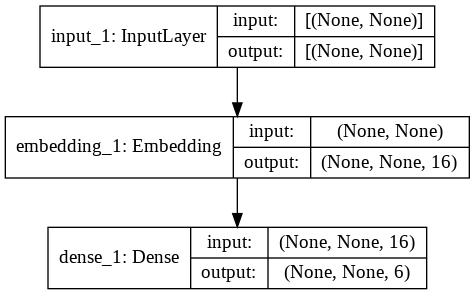

In [ ]:
model = bulid_model(n_vocab , 16)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## Data

In [ ]:
text = """수학은 수식이 복잡해서 어렵다
수학은 공식이 많아서 어렵다
수학은 수식이 이해되면 쉽다
수학은 공식이 능통하면 쉽다
영어는 단어가 많아서 어렵다
영어는 듣기가 복잡해서 어렵다
영어는 단어가 이해되면 쉽다
영어는 듣기가 능통하면 쉽다
국어는 지문이 복잡해서 어렵다
국어는 한문이 많아서 어렵다
국어는 지문이 이해되면 쉽다
국어는 한문이 능통하면 쉽다"""

## vocabulary

In [ ]:
words = []

for w in text.split():
    words.append(w)

words = list(dict.fromkeys(words))
# words = dict.fromkeys(words)
words

['수학은',
 '수식이',
 '복잡해서',
 '어렵다',
 '공식이',
 '많아서',
 '이해되면',
 '쉽다',
 '능통하면',
 '영어는',
 '단어가',
 '듣기가',
 '국어는',
 '지문이',
 '한문이']

In [ ]:
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

{'[PAD]': 0,
 '[UNK]': 1,
 '공식이': 6,
 '국어는': 14,
 '능통하면': 10,
 '단어가': 12,
 '듣기가': 13,
 '많아서': 7,
 '복잡해서': 4,
 '수식이': 3,
 '수학은': 2,
 '쉽다': 9,
 '어렵다': 5,
 '영어는': 11,
 '이해되면': 8,
 '지문이': 15,
 '한문이': 16}

In [ ]:
id_to_word = {_id:w for w, _id in word_to_id.items()}
id_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '수학은',
 3: '수식이',
 4: '복잡해서',
 5: '어렵다',
 6: '공식이',
 7: '많아서',
 8: '이해되면',
 9: '쉽다',
 10: '능통하면',
 11: '영어는',
 12: '단어가',
 13: '듣기가',
 14: '국어는',
 15: '지문이',
 16: '한문이'}

## Train, Valid, Test 데이터 생성

In [ ]:
src = text.split('\n')
src

['수학은 수식이 복잡해서 어렵다',
 '수학은 공식이 많아서 어렵다',
 '수학은 수식이 이해되면 쉽다',
 '수학은 공식이 능통하면 쉽다',
 '영어는 단어가 많아서 어렵다',
 '영어는 듣기가 복잡해서 어렵다',
 '영어는 단어가 이해되면 쉽다',
 '영어는 듣기가 능통하면 쉽다',
 '국어는 지문이 복잡해서 어렵다',
 '국어는 한문이 많아서 어렵다',
 '국어는 지문이 이해되면 쉽다',
 '국어는 한문이 능통하면 쉽다']

In [ ]:
def make_data(src, n_win):
    inputs, labels = [], []

    for s in src:
        print(s)

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

train_inputs, train_labels = make_data(src,2)
train_inputs, train_labels


수학은 수식이 복잡해서 어렵다
수학은 공식이 많아서 어렵다
수학은 수식이 이해되면 쉽다
수학은 공식이 능통하면 쉽다
영어는 단어가 많아서 어렵다
영어는 듣기가 복잡해서 어렵다
영어는 단어가 이해되면 쉽다
영어는 듣기가 능통하면 쉽다
국어는 지문이 복잡해서 어렵다
국어는 한문이 많아서 어렵다
국어는 지문이 이해되면 쉽다
국어는 한문이 능통하면 쉽다


(array([], dtype=float64), array([], dtype=float64))

In [ ]:
def make_data(src, n_win):
    inputs, labels = [], []

    for s in src:
        tokens = s.split()
        for i, c in enumerate(tokens):
            print(i,c)

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(src,2)
train_inputs, train_labels

# center word를 각각 문장마다 만들엇어

0 수학은
1 수식이
2 복잡해서
3 어렵다
0 수학은
1 공식이
2 많아서
3 어렵다
0 수학은
1 수식이
2 이해되면
3 쉽다
0 수학은
1 공식이
2 능통하면
3 쉽다
0 영어는
1 단어가
2 많아서
3 어렵다
0 영어는
1 듣기가
2 복잡해서
3 어렵다
0 영어는
1 단어가
2 이해되면
3 쉽다
0 영어는
1 듣기가
2 능통하면
3 쉽다
0 국어는
1 지문이
2 복잡해서
3 어렵다
0 국어는
1 한문이
2 많아서
3 어렵다
0 국어는
1 지문이
2 이해되면
3 쉽다
0 국어는
1 한문이
2 능통하면
3 쉽다


(array([], dtype=float64), array([], dtype=float64))

In [ ]:
# window 만들기

def make_data(src, n_win):
    inputs, labels = [], []

    for s in src:
        tokens = s.split()
        for i, c in enumerate(tokens):
            left = max(i - n_win, 0) # 0보다 작은건 없애야 되니까
            right = min(i+n_win, len(tokens)-1) # len 보다 더 큰건 없어야되니까 

            print(i,c, left, right)

    # inputs = np.array(inputs)
    # labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(src,2)
train_inputs
train_labels


0 수학은 0 2
1 수식이 0 3
2 복잡해서 0 3
3 어렵다 1 3
0 수학은 0 2
1 공식이 0 3
2 많아서 0 3
3 어렵다 1 3
0 수학은 0 2
1 수식이 0 3
2 이해되면 0 3
3 쉽다 1 3
0 수학은 0 2
1 공식이 0 3
2 능통하면 0 3
3 쉽다 1 3
0 영어는 0 2
1 단어가 0 3
2 많아서 0 3
3 어렵다 1 3
0 영어는 0 2
1 듣기가 0 3
2 복잡해서 0 3
3 어렵다 1 3
0 영어는 0 2
1 단어가 0 3
2 이해되면 0 3
3 쉽다 1 3
0 영어는 0 2
1 듣기가 0 3
2 능통하면 0 3
3 쉽다 1 3
0 국어는 0 2
1 지문이 0 3
2 복잡해서 0 3
3 어렵다 1 3
0 국어는 0 2
1 한문이 0 3
2 많아서 0 3
3 어렵다 1 3
0 국어는 0 2
1 지문이 0 3
2 이해되면 0 3
3 쉽다 1 3
0 국어는 0 2
1 한문이 0 3
2 능통하면 0 3
3 쉽다 1 3


[]

In [ ]:
# window 만들기

def make_data(src, n_win):
    inputs, labels = [], []

    for s in src:
        tokens = s.split()
        for i, c in enumerate(tokens):
            left = max(i - n_win, 0) # 0보다 작은건 없애야 되니까
            right = min(i+n_win, len(tokens)-1) # len 보다 더 큰건 없어야되니까 
            os = [tokens[j] for j in range(left, right + 1) if i != j]
            print(i,c, os)

    # inputs = np.array(inputs)
    # labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(src,2)
train_inputs, train_labels

0 수학은 ['수식이', '복잡해서']
1 수식이 ['수학은', '복잡해서', '어렵다']
2 복잡해서 ['수학은', '수식이', '어렵다']
3 어렵다 ['수식이', '복잡해서']
0 수학은 ['공식이', '많아서']
1 공식이 ['수학은', '많아서', '어렵다']
2 많아서 ['수학은', '공식이', '어렵다']
3 어렵다 ['공식이', '많아서']
0 수학은 ['수식이', '이해되면']
1 수식이 ['수학은', '이해되면', '쉽다']
2 이해되면 ['수학은', '수식이', '쉽다']
3 쉽다 ['수식이', '이해되면']
0 수학은 ['공식이', '능통하면']
1 공식이 ['수학은', '능통하면', '쉽다']
2 능통하면 ['수학은', '공식이', '쉽다']
3 쉽다 ['공식이', '능통하면']
0 영어는 ['단어가', '많아서']
1 단어가 ['영어는', '많아서', '어렵다']
2 많아서 ['영어는', '단어가', '어렵다']
3 어렵다 ['단어가', '많아서']
0 영어는 ['듣기가', '복잡해서']
1 듣기가 ['영어는', '복잡해서', '어렵다']
2 복잡해서 ['영어는', '듣기가', '어렵다']
3 어렵다 ['듣기가', '복잡해서']
0 영어는 ['단어가', '이해되면']
1 단어가 ['영어는', '이해되면', '쉽다']
2 이해되면 ['영어는', '단어가', '쉽다']
3 쉽다 ['단어가', '이해되면']
0 영어는 ['듣기가', '능통하면']
1 듣기가 ['영어는', '능통하면', '쉽다']
2 능통하면 ['영어는', '듣기가', '쉽다']
3 쉽다 ['듣기가', '능통하면']
0 국어는 ['지문이', '복잡해서']
1 지문이 ['국어는', '복잡해서', '어렵다']
2 복잡해서 ['국어는', '지문이', '어렵다']
3 어렵다 ['지문이', '복잡해서']
0 국어는 ['한문이', '많아서']
1 한문이 ['국어는', '많아서', '어렵다']
2 많아서 ['국어는', '한문이', '어렵다']
3 어렵다 ['한문이', '많아서']
0 국어

([], [])

In [ ]:
def make_data(src, n_win):
    inputs, labels = [], []

    for s in src:
        tokens = s.split()
        for i, c in enumerate(tokens):
            left = max(i - n_win, 0) # 0보다 작은건 없애야 되니까
            right = min(i+n_win, len(tokens)-1) # len 보다 더 큰건 없어야되니까 
            os = [tokens[j] for j in range(left, right + 1) if i != j]
            for o in os:
                inputs.append(c) # 기준단어
                labels.append(o) # 윈도우 단어들?
                
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(src,2)
print(train_inputs)
print(train_labels)


['수학은' '수학은' '수식이' '수식이' '수식이' '복잡해서' '복잡해서' '복잡해서' '어렵다' '어렵다' '수학은'
 '수학은' '공식이' '공식이' '공식이' '많아서' '많아서' '많아서' '어렵다' '어렵다' '수학은' '수학은' '수식이'
 '수식이' '수식이' '이해되면' '이해되면' '이해되면' '쉽다' '쉽다' '수학은' '수학은' '공식이' '공식이' '공식이'
 '능통하면' '능통하면' '능통하면' '쉽다' '쉽다' '영어는' '영어는' '단어가' '단어가' '단어가' '많아서' '많아서'
 '많아서' '어렵다' '어렵다' '영어는' '영어는' '듣기가' '듣기가' '듣기가' '복잡해서' '복잡해서' '복잡해서'
 '어렵다' '어렵다' '영어는' '영어는' '단어가' '단어가' '단어가' '이해되면' '이해되면' '이해되면' '쉽다' '쉽다'
 '영어는' '영어는' '듣기가' '듣기가' '듣기가' '능통하면' '능통하면' '능통하면' '쉽다' '쉽다' '국어는' '국어는'
 '지문이' '지문이' '지문이' '복잡해서' '복잡해서' '복잡해서' '어렵다' '어렵다' '국어는' '국어는' '한문이'
 '한문이' '한문이' '많아서' '많아서' '많아서' '어렵다' '어렵다' '국어는' '국어는' '지문이' '지문이' '지문이'
 '이해되면' '이해되면' '이해되면' '쉽다' '쉽다' '국어는' '국어는' '한문이' '한문이' '한문이' '능통하면'
 '능통하면' '능통하면' '쉽다' '쉽다']
['수식이' '복잡해서' '수학은' '복잡해서' '어렵다' '수학은' '수식이' '어렵다' '수식이' '복잡해서' '공식이'
 '많아서' '수학은' '많아서' '어렵다' '수학은' '공식이' '어렵다' '공식이' '많아서' '수식이' '이해되면' '수학은'
 '이해되면' '쉽다' '수학은' '수식이' '쉽다' '수식이' '이해되면' '공식이' '능통하면' '수학은' '능통하면' '쉽다'
 '수학은' '공식이' '쉽다' '공식이' '능통하면' '단어가

In [ ]:
src

['수학은 수식이 복잡해서 어렵다',
 '수학은 공식이 많아서 어렵다',
 '수학은 수식이 이해되면 쉽다',
 '수학은 공식이 능통하면 쉽다',
 '영어는 단어가 많아서 어렵다',
 '영어는 듣기가 복잡해서 어렵다',
 '영어는 단어가 이해되면 쉽다',
 '영어는 듣기가 능통하면 쉽다',
 '국어는 지문이 복잡해서 어렵다',
 '국어는 한문이 많아서 어렵다',
 '국어는 지문이 이해되면 쉽다',
 '국어는 한문이 능통하면 쉽다']

In [ ]:
def make_data(src, n_win):
    inputs, labels = [], []

    for s in src:
        tokens = s.split()
        for i, c in enumerate(tokens):
            left = max(i - n_win, 0) # 0보다 작은건 없애야 되니까
            right = min(i+n_win, len(tokens)-1) # len 보다 더 큰건 없어야되니까 
            os = [tokens[j] for j in range(left, right + 1) if i != j]
            for o in os:
                inputs.append(word_to_id[c])
                labels.append(word_to_id[o])
                
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(src,2)
print(train_inputs)
print(train_labels)


[ 2  2  3  3  3  4  4  4  5  5  2  2  6  6  6  7  7  7  5  5  2  2  3  3
  3  8  8  8  9  9  2  2  6  6  6 10 10 10  9  9 11 11 12 12 12  7  7  7
  5  5 11 11 13 13 13  4  4  4  5  5 11 11 12 12 12  8  8  8  9  9 11 11
 13 13 13 10 10 10  9  9 14 14 15 15 15  4  4  4  5  5 14 14 16 16 16  7
  7  7  5  5 14 14 15 15 15  8  8  8  9  9 14 14 16 16 16 10 10 10  9  9]
[ 3  4  2  4  5  2  3  5  3  4  6  7  2  7  5  2  6  5  6  7  3  8  2  8
  9  2  3  9  3  8  6 10  2 10  9  2  6  9  6 10 12  7 11  7  5 11 12  5
 12  7 13  4 11  4  5 11 13  5 13  4 12  8 11  8  9 11 12  9 12  8 13 10
 11 10  9 11 13  9 13 10 15  4 14  4  5 14 15  5 15  4 16  7 14  7  5 14
 16  5 16  7 15  8 14  8  9 14 15  9 15  8 16 10 14 10  9 14 16  9 16 10]


In [ ]:
# valid_inputs, valid_labels = make_data(valid_src, valid_tgt, 6)
# valid_inputs, valid_labels

In [ ]:
# test_inputs, test_labels = make_data(test_src, test_tgt, 4)
# test_inputs, test_labels

## Modeling

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32

args

Namespace(d_model=32, n_vocab=17, seed=1234)

In [ ]:

def build_model(args):
    inputs = tf.keras.layers.Input(shape = (None,))

    V = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    v_c = V(inputs)

    U = tf.keras.layers.Dense(args.n_vocab, use_bias = False, activation = tf.nn.softmax)
    y_pred = U(v_c)

    model = tf.keras.Model(inputs = inputs, outputs = y_pred)
    return model ,V

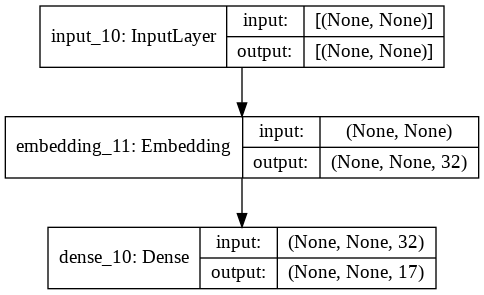

In [ ]:
model,V = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## 백터 출력

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
def plot_embedding(v , word_to_id):
    plt.figure(figsize = (8,8))
    plt.rc('font', family = 'NanumBarunGothic')
    plt.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시- 깨지는 문제 해결

    vectors = []
    words = []
    for word, _id in word_to_id.items():
        print(word, _id)
        


In [ ]:
embed = tf.keras.layers.Embedding(args.n_vocab, args.d_model)

In [ ]:
plot_embedding(embed, word_to_id)

[PAD] 0
[UNK] 1
수학은 2
수식이 3
복잡해서 4
어렵다 5
공식이 6
많아서 7
이해되면 8
쉽다 9
능통하면 10
영어는 11
단어가 12
듣기가 13
국어는 14
지문이 15
한문이 16


<Figure size 576x576 with 0 Axes>

In [ ]:
def plot_embedding(v , word_to_id):
    plt.figure(figsize = (8,8))
    plt.rc('font', family = 'NanumBarunGothic')
    plt.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시- 깨지는 문제 해결

    vectors = []
    words = []
    for word, _id in word_to_id.items():
        if 1 < _id:
            vectors.append(v(_id))
            words.append(word)
            
    print(vectors)
    print(words)

In [ ]:
plot_embedding(embed, word_to_id)

[<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.02696644,  0.02260647,  0.01062956, -0.04740093, -0.04329621,
        0.0052838 ,  0.01617347, -0.04441366,  0.04973597,  0.02107234,
        0.01476629, -0.03926431,  0.01426322, -0.04107127, -0.02626084,
       -0.02395394, -0.02078225, -0.03866898,  0.00536219, -0.03451126,
       -0.04116478, -0.03110768, -0.00336798,  0.02939374, -0.00384907,
       -0.02763172,  0.01591932, -0.01311845,  0.03692505,  0.0414484 ,
       -0.01221111, -0.01739891], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 0.04383499, -0.00708938, -0.03699385, -0.02875987, -0.01364012,
       -0.02384666,  0.03288158, -0.03738077, -0.02849819, -0.03913441,
       -0.04544015, -0.00341319,  0.034396  ,  0.02263136,  0.02549123,
       -0.04262656,  0.03866441, -0.01650457, -0.0216445 ,  0.02020346,
        0.0038653 ,  0.00437702,  0.01181028, -0.01945369, -0.01788511,
       -0.00820525,  0.01422581,  0.02365283, -0.03109006,  0.

<Figure size 576x576 with 0 Axes>

In [ ]:
def plot_embedding(v , word_to_id):
    plt.figure(figsize = (8,8))
    plt.rc('font', family = 'NanumBarunGothic')
    plt.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시- 깨지는 문제 해결

    vectors = []
    words = []
    for word, _id in word_to_id.items():
        vectors.append(v(_id))
        words.append(word)
    vectors = PCA().fit_transform(vectors)[:, :2]

    for word, vector in zip(words, vectors):
        plt.scatter(vector[0], vector[1])
        plt.text(vector[0], vector[1], word)
    

    plt.show()

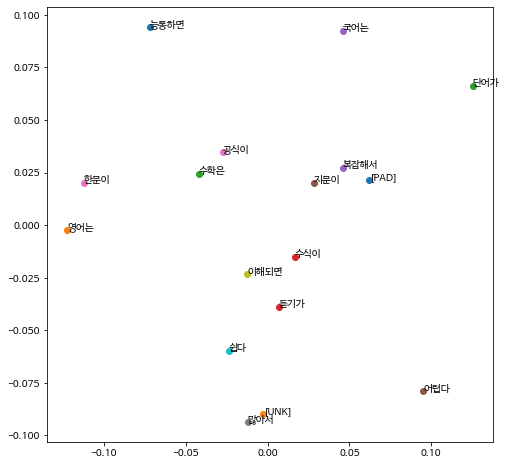

In [ ]:
plot_embedding(embed, word_to_id)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input(shape=(None,))

    V = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    v_c = V(inputs)

    U = tf.keras.layers.Dense(args.n_vocab, use_bias=False, activation=tf.nn.softmax)
    y_pred = U(v_c)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model, V


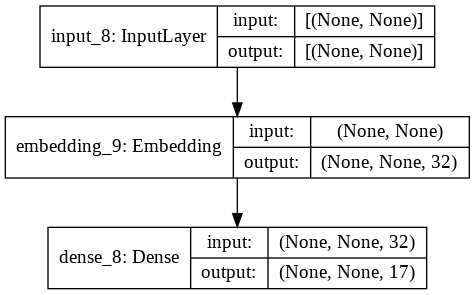

In [ ]:
model, V = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes = True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy'])


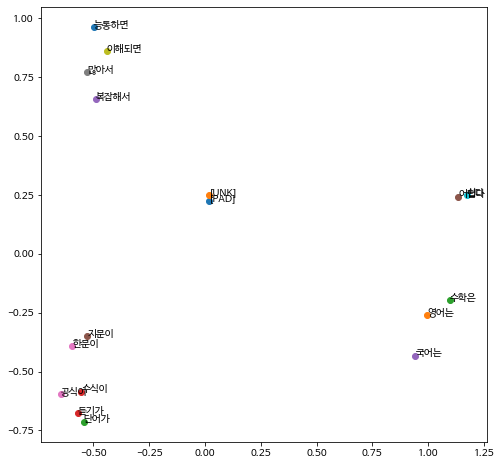

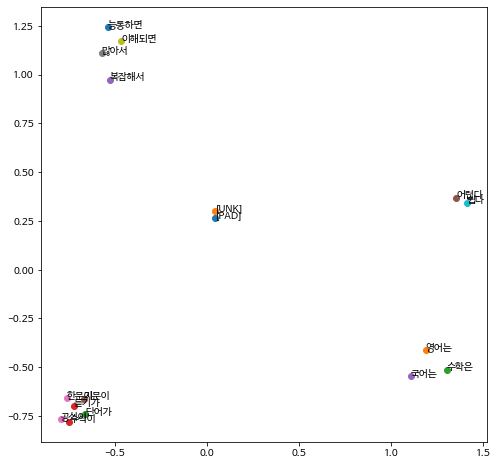

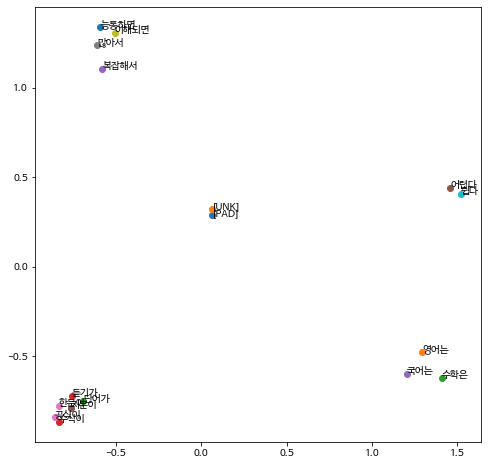

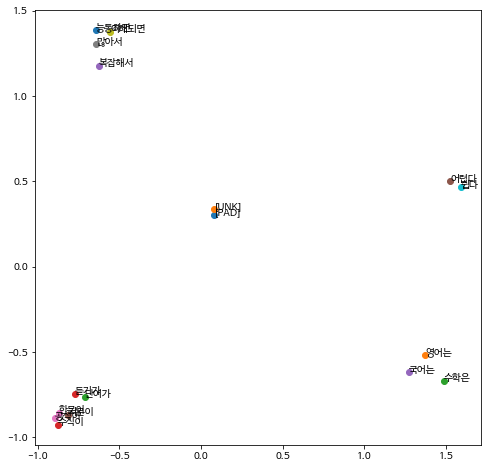

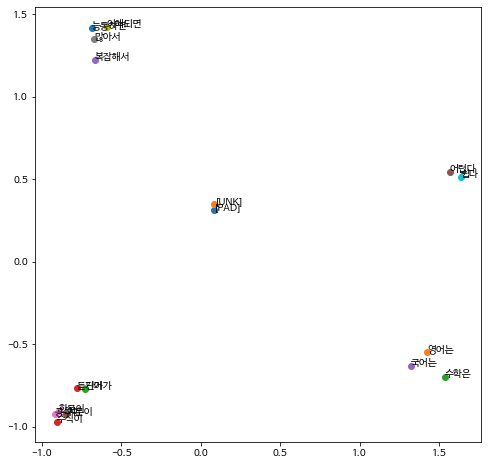

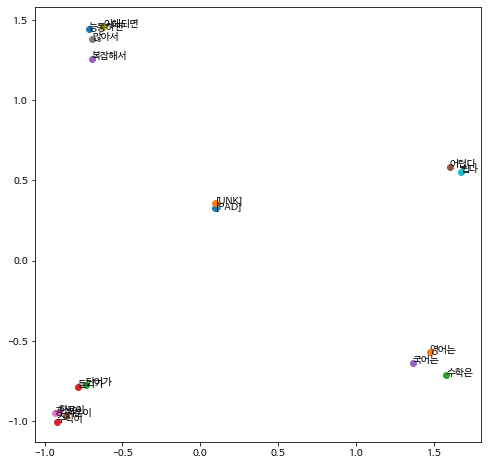

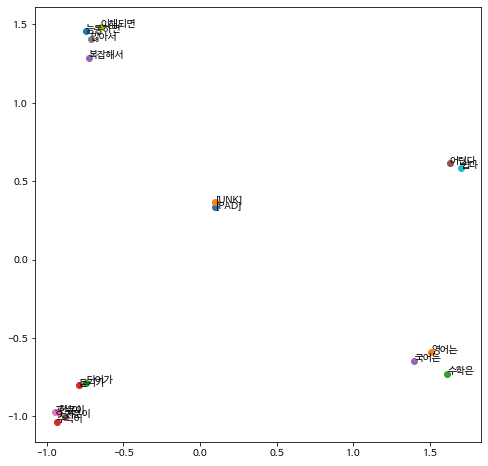

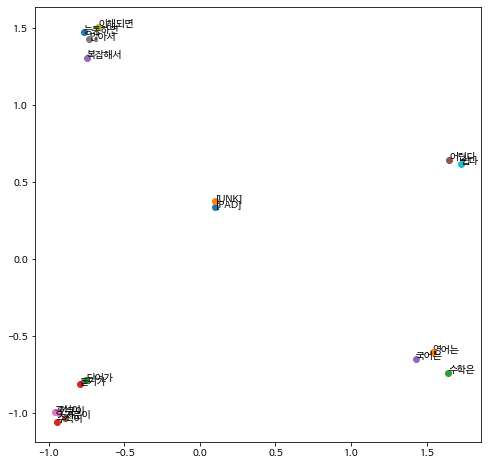

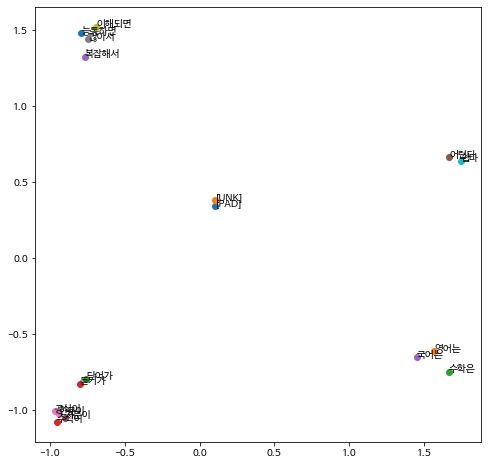

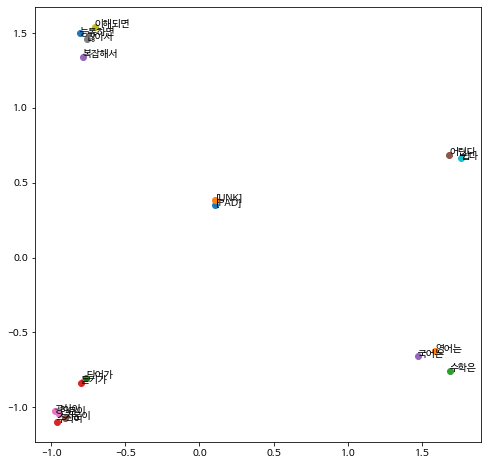

In [ ]:
for i in range(10):
    history = model.fit(train_inputs, train_labels,
                        epochs = 100,
                        batch_size = 8,
                        verbose = 0)
    plot_embedding(V, word_to_id)

# 비지도 학습인거지

## Gensim

In [ ]:
import gensim
import gensim.downloader as api

In [ ]:
wv = api.load('glove-wiki-gigaword-100') # 128m

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
len(wv.vocab)

400000

In [ ]:
for i,word in enumerate(wv.vocab):
    if i >= 20:
        break
    print(word)

the
,
.
of
to
and
in
a
"
's
for
-
that
on
is
was
said
with
he
as


In [ ]:
wv.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.927285373210907),
 ('clinton', 0.8960003852844238),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933663129806519),
 ('dole', 0.7851964235305786),
 ('rodham', 0.751889705657959),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472623586654663)]

In [ ]:
wv.most_similar(positive = ['woman', 'king'], negative = ['man'])

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [ ]:
def analogy(p1, n1, p2):
    result = wv.most_similar(positive = [p2,p1], negative = ['n1'])
    return result

In [ ]:
analogy('king', 'man','woman')

[('father', 0.7743557691574097),
 ('mother', 0.7680771350860596),
 ('wife', 0.7235965728759766),
 ('brother', 0.7223226428031921),
 ('man', 0.7187163829803467),
 ('husband', 0.7148180603981018),
 ('son', 0.704011082649231),
 ('daughter', 0.7018743753433228),
 ('couple', 0.7002776861190796),
 ('friend', 0.6941061019897461)]

In [ ]:
analogy('american', 'korean', 'japanese')

[('u.s.', 0.6680246591567993),
 ('canadian', 0.6572072505950928),
 ('british', 0.6471949219703674),
 ('chinese', 0.6395125389099121),
 ('americans', 0.6386282444000244),
 ('german', 0.6364268064498901),
 ('foreign', 0.6197013258934021),
 ('well', 0.6073771119117737),
 ('even', 0.6067825555801392),
 ('ago', 0.6059406995773315)]

## 배포

In [ ]:
model = build_model(args)
model.load_weights("stub.hdf5")

In [ ]:
string = "수학 당신은 선생님 입니다"

In [ ]:
infer_input = [word_to_id[w] for w in string.split()]
infer_input = np.array([infer_input])
infer_input

array([[6, 5, 7, 4]])

In [ ]:
train_inputs.shape, infer_input.shape

((2, 5), (1, 4))

In [ ]:
y_pred = model.predict(infer_input)
y_pred

array([[[0.43229845, 0.5677016 ],
        [0.5931056 , 0.40689442],
        [0.458534  , 0.541466  ],
        [0.5983461 , 0.40165392]]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([[1, 0, 1, 0]])

In [ ]:
for row in y_class:
    for val in row:
        print(f"{val} : {id_to_label[val]}")

1 : 명사
0 : 기타
1 : 명사
0 : 기타


In [ ]:
def do_predict(model, string):
    tokens = string.split()
    infer_input = []
    for w in tokens:
        infer_input.append(word_to_id.get(w, 1))
    infer_input = np.array([infer_input])
    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    result = []
    for w, c in zip(tokens, y_class):
        result.append([w, id_to_label[c]])
    return result

In [ ]:
do_predict(model, "수학 당신은 과학 선생님 입니다")

[['수학', '명사'], ['당신은', '기타'], ['과학', '기타'], ['선생님', '명사'], ['입니다', '기타']]

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 나는 중학생 입니다
[['나는', '기타'], ['중학생', '기타'], ['입니다', '기타']]
input> 당신은 우리학교 선생님 입니다.
[['당신은', '기타'], ['우리학교', '기타'], ['선생님', '명사'], ['입니다.', '기타']]
input> 
